# Implenting an ANN in Python and NumPy

This task is about classifying handwritten digits. We will use the MNIST dataset for training and testing.

The point of this task is to develop a multi-layer neural network for classification using Python and  Numpy:

- Implement sigmoid and relu layers (with forward and backward pass)
- Implement a softmax output layer
- Implement a fully parameterizable neural network (number and types of layers, number of units)
- Implement an optimizer (e.g. SGD or Adam) and a stopping criterion of your choosing
- Train your Neural Network using backpropagation

Evaluate different neural network architectures and compare your different results.



#### Imports

This artificial neural network model uses the MNIST dataset, which is composed by a total of 70,000 images of handwritten digits, and each image is comprised by a 28x28 pixel array. This model is an example of a supervised training framework which aims to accurately predict the correct class of the handwritten digit image, taking as inputs the 28x28 arrays.

Below we are importing the necessary packages.

This artificial neural network model is implemented in pure numpy and excess imported libraries are only used to import the mnist dataset and to provide data visualizations. 

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import numpy as np
from keras.datasets import mnist
import collections
from collections import OrderedDict
import seaborn as sns


Using TensorFlow backend.


#### Plotting Functions

In this section we are creating the plot visualization functions, which we will use subsequently to evaluate the mnist dataset and the model's results.

The confusion matrix and heat map plots, will be used to show us the number of TP, TN, FN, FP, in order to be able to vizualize evalute and better understand our model's accuracy performance, error value and other useful classification metrics.

The bar chart we will provide a representation of the number of data provided for each digit (0 - 9). An uneven training set could lead to inferior results, for example a supervised model "teached" on an unbalanced training set could produce a neural network that accurately recognizes digits with more data points, while recognitions of digits with trivial data will be prone to innacurate classifications.

Lastly, a two principal component analysis scatter plot will provide us with an insight on each digit's categorical class variance on the two components, resulting to a better understanding of each categorical class misclassifications.

In [2]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.05)
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plot_heatmap(confusion):
    heat = sns.heatmap(confusion, square=True, annot=True, cbar=False)
    plt.xlabel('predicted value')
    plt.ylabel('true value')


def plot_pca(train_x, train_y):
    pca = PCA(2)
    projected = pca.fit_transform(train_x)
    plt.scatter(projected[:, 0], projected[:, 1], c=train_y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.xlabel('pca component 1')
    plt.ylabel('pca component 2')
    plt.colorbar()


def plot_bar_chart(labels, values):
    plt.bar(labels, values, 1, edgecolor='y')
    plt.xticks(labels)
    plt.ylabel("Data Number")
    plt.xlabel("Class Labels")
    plt.show()

#### Artificial Neural Network Overview

This model is a fully parameterizable artificial neural network with the ability of the user adding multiple hidden layers and activation functions. The type of layers implemented in this task are:

- Fully Connected (Dense) Layer
- Sigmoid Activation Layer
- ReLU Activation Layer
- Softmax Activation Layer (used as the activation function of the output layer)

The optimizing algorithm used in this project is the <b>Mini-Batch Gradient Descent</b> implemented with the options of enabling learning rate decay, while also weight and bias momentum to further improve the optimization of the weights and bias parameters.

The loss function used in this project is <b>Cross Entropy</b>, which calculates the loss of our model by taking the negative log value of the predicted probabilities produced by the softmax layer and comparing them with the actual label probabilities.
Example: an image of a 9 will have 1 probability of being 9 and 0 probabilities for the rest classification labels, if our model predicted a probability of 0.10 of being a nine, cross entropy loss = -log(1 - 0.1). This is done exponentially to calculate the loss of epochs and the model's total training loss.

#### Fully Connected (Dense) Layer Class

Fully Connected layers or also known as Dense layers are consisted by a number of neurons where each neuron is connected to all the neurons of the next layer. A given layer's output becomes the input of the next layer. Every link from one neuron to another has a corresponding weight, that denotes the quantity of the input to be utilized, mathematically this is accomplished by multiplying the input with the assosiated link weight. After a neuron has received the total number of data, which is comprised by the total number of inputs multiplied by their corresponding connection weight summarized, the 'bias' variable is added which is another parameter to be shifted towards constructing a superior model. 

The "Fully_Connected_Layer" class take as arguments the number of inputs and the units variable which referes to the dimensionality of the layer's output. Creating an instance of the Fully_Connected_Layer class will initialize the instances of the biases, weights, weights momentums and biases momentums which are all arrays with dimensionalities equal to the value of the dimensionality of the layer's output.



In [3]:
class Fully_Connected_Layer:
    def __init__(self, neurons, output_units):
        self.output_units = output_units  # Output dimensions
        self.bias = np.zeros((1, output_units))  # initialize bias array
        self.weights = np.random.randn(neurons, output_units) * 0.05  # initialize weights with small scale values
        self.w_momentums = np.zeros_like(self.weights)  # initialize weight momentum array
        self.b_momentums = np.zeros_like(self.bias)  # initialize bias momentum array

    def forward_pass(self, layer_inputs):
        self.layer_inputs = layer_inputs  # save layer_inputs to self object used in backprop
        self.layer_output = np.dot(layer_inputs, self.weights) + self.bias  # dot product of layer inputs with weights

    def backward_pass(self, grad_inputs):
        self.grad_weights = np.dot(self.layer_inputs.T, grad_inputs)  # transpose values to fit the weights dimensions
        self.grad_bias = np.sum(grad_inputs, axis=0, keepdims=True)  # derivatives of weights and bias used to optimize the layer's weights and bias values
        self.grad_output = np.dot(grad_inputs, self.weights.T)  # transpose weights to fit neurons of layer dimensions


#### ReLU and Sigmoid Activation Layers

Activation functions in an artificial neural network assist the model to recognize and process complicated patterns found in data, filtering a layer's input. The main reason of using activation functions in a neural network is their ability to fit non-linear functions.

The rectified linear activation function or rectified linear activation unit when used by a unit (<b>ReLU</b>) performs a simple calculation to convert values of negative inputs to 0 or pass positive input values directly to the next layer of the neural network. The derivate of the ReLU function is equal to its slope, which is 1 for positive values and 0 for negative values.

There are various types of variations of the sigmoid function, in this scenario we are implementing the <b>logistic sigmoid</b> activation function which has a formula of: sigmoid = 1/(1+e^(-x)), it takes some input values and outputs a value between 0 and 1 that can be portrayed as a probability. The derivative of the sigmoid function can be then calculated as: sigmoid * (1 - sigmoid) * x 

In [4]:
class ReLU_Layer:
    def forward_pass(self, layer_inputs):
        self.layer_inputs = layer_inputs
        self.layer_output = np.maximum(layer_inputs, 0)  # replace negative elements with 0

    def backward_pass(self, grad_inputs):
        self.grad_output = grad_inputs.copy()
        self.grad_output[self.layer_inputs <= 0] = 0  # derivative of ReLU


class Sigmoid_Layer:
    def forward_pass(self, layer_inputs):
        self.layer_inputs = layer_inputs
        self.layer_output = 1 / (1 + np.exp(-layer_inputs))  # apply sigmoid formula

    def backward_pass(self, grad_inputs):
        self.grad_output = self.layer_output * (1 - self.layer_output) * grad_inputs  # derivative of sigmoid


#### Softmax Output Layer

The process of forward and backward pass of the softmax activation layer combined with the cross entropy loss function can be broken down into steps:

- First, the softmax activation function is used at the output layer to get the likelihoods of each categorical class that sum up to 1 getting input from the previous fully connected layer of the neural network. 


- -np.max() is used in the softmax formula to normalize float values by substracting the maximum input that the softmax layer received. 


- Then the class with the highest likelihood is evaluated as the neural network prediction and is compared to the actual label which has a probability of 1. The output of the softmax layer is forward propagated and processed by the cross entropy loss function to calculate the loss value for the neural network model by taking the mean negative log values of the probabiities (this process is repeated for the total, epoch and batch loss values). 


- The partial derivatives of the softmax and cross entropy loss functions are combined to provide a much simpler formula for back propagating through these layers.

In [5]:
class Softmax_Layer:
    def forward_pass(self, layer_inputs):
        self.layer_inputs = layer_inputs
        exponential = np.exp(self.layer_inputs - np.max(self.layer_inputs, axis=1, keepdims=True))  # forward pass apply softmax formula
        likelihoods = exponential / np.sum(exponential, axis=1, keepdims=True)  # calculate softmax probabilities output
        self.layer_output = likelihoods  # save probabilities in self object as layer_output
        

#### Cross Entropy Loss

As mentioned above Cross Entropy Loss class is being synthesized with the Softmax Layer class to back propagate faster through these steps of the neural network.

In the forward_pass function the arguments passed are the probabilities predicted by the softmax layer and the actual image labels. The probabilities predicted for the actual labels are then filtered and gathered in a new array, while the probabilities for the wrong categorical classes are discarded. Finally the loss is calculated by taking the negative log of the correct probabilities.

For one-hot encoding classification problems, the formula of the cross entropy derivative with softmax can be simplified to <b>P(pk) - P(yk)</b> where k is the digit of the image that is being classified, P(pk) is the predicted likelihood estimated by the neural network for class k and P(yk) is the actual probability of the class which is always 1 since there is only one correct label. For example for an image of a 0, if our neural network predicted a probability of 0.30 for that image to be a 0, then the gradient of the cross entropy with softmax would be equal to 0.30 - 1 = -0.7.



In [6]:
class CrossEntropyLoss:
    def forward_pass(self, predicted, labels):
        predicted = np.clip(predicted, 1e-10, 1 - 1e-10)  # probabilities for all classes
        predicted_probabilities = predicted[range(len(predicted)), labels]  # probabilities of classes equal to labels 
        log_likelihoods = -np.log(predicted_probabilities)  # cross entropy loss
        data_loss = np.mean(log_likelihoods)  # mean of loss values
        self.batch_losses_sum += np.sum(log_likelihoods)  # batch loss values
        self.batch_losses += len(log_likelihoods)  # number of samples in batch
        return data_loss

    def backward_pass(self, grad_inputs, labels):
        self.grad_output = grad_inputs.copy()  # make safe copy
        self.grad_output[range(len(grad_inputs)), labels] -= 1  # Calculating gradient
        layer_output = self.grad_output / len(grad_inputs)  # Normalizing
        return layer_output

    def epoch_loss(self):
        loss = self.batch_losses_sum / self.batch_losses  # calculate epoch loss
        return loss

    def new_epoch(self):
        self.batch_losses_sum = 0  # reset batch loss variables
        self.batch_losses = 0


#### Combined Softmax and Cross Entropy Layer

In [7]:
class Softmax_CrossEntropy_Loss_Layer:
    def __init__(self):
        self.softmax = Softmax_Layer()  # creating instance of softmax layer class
        self.loss = CrossEntropyLoss()  # creating instance of crossentropy loss class

    def forward_pass(self, layer_inputs, y_true):
        self.softmax.forward_pass(layer_inputs)  # get probabilities of softmax
        self.layer_output = self.softmax.layer_output  # save probabilities to self
        return self.loss.forward_pass(self.layer_output, y_true)  #  calculate loss with cross entropy by passing softmax probabilities

    def backward_pass(self, grad_inputs, y_true):
        self.grad_output = self.loss.backward_pass(grad_inputs, y_true)  # back propagate through cross entropy and softmax combined formula

#### Mini-Batch Gradient Descent Optimizer

<b>Mini-Batch Gradient Descent </b> is an optimization algorithm that work towards minimizing the error value of the loss function, by tuning neural network parameters such as the weights, biases and the learning rate, while iterating over the training data. The aim of an optimizer function is to drive the error value towards 0, yielding the lowest possible cost. There are multiple versions of different optimizers based on the concept of Gradient Descent, the mini-batch gradient descent optimizer get its name because it splits the dataset into many smaller batches, then iterates through them gradually and tweaks the weights, bias and learning rate, based on the error found in each batch.

The <b>learning rate (lr</b>) is the hyperparameter that tunes the magnitude of shifting the weights and the bias values, in simpler words it manages the rate of the model's "learning". A high learning rate value will result to bigger steps and vice versa, the model aims to reach the global minimum of a function if considered as a graph, by reaching the global minimum the model achieves the lowest possible error for the neural network model. Generally gradient descent optimizers have trouble reaching the global minimum in functions due to the existence of local minimums that can prevent the neural network model from reaching an optimal accuracy. 

Learning rate is being updated through a time-based decay design, with formula <b>lr = lr * (1 / (1 + self.lr_decay * self.loop_number))</b>.

Lastly momentums values are updated each time the optimizer takes action to adjust the weight and bias values. Momentums are equal to the amount of change in weights and bias values in each batch cycle of the neural network.

In [8]:
class MiniBatch_GradientDescent_Optimizer:
    def __init__(self, lr=1, lr_decay=0, momentum=0):
        # initiate and store parameters of optimizer to self
        self.lr = lr
        self.lr_decay = lr_decay
        self.loop_number = 0
        self.momentum = momentum

    def update_learning_rate(self):
        self.lr = self.lr * (1 / (1 + self.lr_decay * self.loop_number))  # update the learning rate 

    def update_weights_bias(self, layer):
        change_w = self.momentum * layer.w_momentums - self.lr * layer.grad_weights  # change of weights
        layer.w_momentums = change_w  # update weight momentums equal to the change of weights

        change_b = self.momentum * layer.b_momentums - self.lr * layer.grad_bias  # change of bias values
        layer.b_momentums = change_b  # update bias momentums equal to the change of bias values
        
        # update layer weights and bias
        layer.weights += change_w  
        layer.bias += change_b

    def update_loop(self):
        self.loop_number += 1  # update loop number


#### Loading the MNIST dataset

In this section, we are loading and splitting the mnist data into testing and training datasets while also calling the "plot_bar_chart" function to check whether the data is properly structured. Once we have separated the data into proper variables we normalize their values to be between 0 and 1 while also ensuring that their type is equal to 'float32' in order to occupy and use a lesser amount of memory.

In [9]:
def data():
    (train_x, train_y), (test_x, test_y) = mnist.load_data()  # Load MNIST Datasets
    print("\n\n" + "-" * 20)
    print("| CHECKING DATA... |")
    print("-" * 20)
    counter = sorted(collections.Counter(train_y).items())  # Check if data of classification classes is balanced
    labels, values = zip(*counter)
    plot_bar_chart(labels, values)
    print("Check min and max values of data...... ", "MIN: ", train_x.min(), "MAX", train_x.max())
    print("Check data shape...... ", train_x.shape)
    train_x = (train_x.reshape(train_x.shape[0], -1).astype(np.float32)) / 255.0  # reshape data 60000, 784
    test_x = (test_x.reshape(test_x.shape[0], -1).astype(np.float32)) / 255.0  # and normalize values between -1 and 1
    print("Data reshaped...... ", train_x.shape,"\n\n")
    return (train_x, train_y), (test_x, test_y)

#### Training, Testing and Architecturing the Artificial Neural Network model

"ANN" is the most significant class in this project, in this section we are architecturing the neural network model.. specifying the number of hidden layers, the number of neurons in each layer, the number of epochs, the samples in each batch and using our pre-structured classes to construct a complete framework. 

This is a fully parameterizable neural network model, with interactive console prompts using an ordered dictionary data structure to store the specifications of the model. The user is asked to provide the number of desired hidden layers, the number of neurons for each layer and their corresponding activation function. This model can be expanded to further implement and be viable with more hidden layer activation functions but the current model supports Sigmoid and ReLU.

The model is trained on the specified training data and then tested on a small amount of data, printing on the console the actual and predicted labels. Neural network parameters such as the learning rate, number of epochs, initial momentum and learning rate can be changed manually within the code.

In the ANN init class we ask the user to input the number of the desired hidden layers, the neurons of each layer and their corresponding activation functions as mentioned above.

In [15]:
class ANN:
    def __init__(self, activation_layers=[], hidden_layer_nodes=[]):
        # Initializing the neural network architecture
        self.activation_layers = activation_layers
        self.hidden_layer_nodes = hidden_layer_nodes
        while True:
            print("-"*59)
            print("| INITIALIZING THE ARTIFICIAL NEURAL NETWORK ARCHITECTURE |")
            print("-" * 59)
            number_of_hidden_layers = input("\nEnter the number of hidden layers: ")
            if number_of_hidden_layers.isdigit():
                number_of_hidden_layers = int(number_of_hidden_layers)
                break
            else:
                print("\nPlease enter an Integer value for the number of hidden layers")
                continue
        print("\nEnter 'relu' for ReLU activation layer or 'sigmoid' for Sigmoid activation layer")
        i = 0
        while i < number_of_hidden_layers:
            layer_activation = input(f"\nEnter the activation function for hidden layer {i}: ")
            number_of_nodes = input(f"\nEnter the number of neurons for hidden layer {i}: ")
            if number_of_nodes.isdigit() and layer_activation == "relu" or layer_activation == "sigmoid":
                self.activation_layers.append(layer_activation)
                self.hidden_layer_nodes.append(int(number_of_nodes))
                i = i + 1
            else:
                print("\n\nPlease check your inputs and try again")
                print("Note: enter 'relu' or 'sigmoid' for activation layer functions\
                 AND an Integer value for the number of layer neurons")
    
    def train_and_test(self):
        # Loading MNIST dataset and splitting data into training and testing sets
        (train_x, train_y), (test_x, test_y) = data()
        
        # PCA plot
        plt.figure()
        plot_pca(train_x, train_y)
        plt.show()

        # Neural's Network Architecture
        network_architecture = OrderedDict()
        activation_layers = self.activation_layers
        hidden_layers = self.hidden_layer_nodes
        network_architecture['input_layer'] = Fully_Connected_Layer(train_x.shape[1], hidden_layers[0])
        for i in range(len(hidden_layers)):
            if activation_layers[i] == "relu":
                network_architecture[f'relu_activation_layer{i+1}'] = ReLU_Layer()
            if activation_layers[i] == "sigmoid":
                network_architecture[f'sigmoid_activation_layer{i+1}'] = Sigmoid_Layer()
            if i != len(hidden_layers) - 1:
                network_architecture[f'hidden_layer{i+1}'] = Fully_Connected_Layer(hidden_layers[i], hidden_layers[i+1])

        network_architecture['output_layer'] = Fully_Connected_Layer(hidden_layers[len(hidden_layers)-1], 10)
        network_architecture['activate_loss'] = Softmax_CrossEntropy_Loss_Layer()
        optimizer = MiniBatch_GradientDescent_Optimizer(lr=0.1, lr_decay=5e-7, momentum=0.7)

        # Printing the model's characteristics
        print("-" * 24)
        print("| NETWORK ARCHITECTURE: |")
        print("-" * 24)
        print(f"ANN LAYERS...".ljust(10) + f" {len(hidden_layers)+2}")
        print(f"HIDDEN LAYERS... ".ljust(10) + f"{len(hidden_layers)}")
        print(f"input layer... input size... {train_x.shape[1]} ...")
        for i in range(len(hidden_layers)):
            print(f"hidden layer{i+1}... neurons... {hidden_layers[i]}")
            print(f"activation layer{i+1}... {activation_layers[i]}")
        print("softmax output layer ... neurons... 10")
        print("LOSS... Categorical Cross-Entropy")
        print("OPTIMIZER... Mini-Batch Gradient Descent")
        
        # Splitting data into batches
        per_batch = 1000
        batches = (len(train_x) // per_batch)
        if batches * per_batch < len(train_x):
            batches += 1

        # Training
        print("\n\n" + "-" * 15)
        print("| TRAINING... |")
        print("-" * 15)
        total_epoch_accuracies = []
        total_epoch_loss = []
        for epoch in range(31):
            total_predictions = []
            network_architecture['activate_loss'].loss.new_epoch()
            batch_accuracies = 0
            batch_accuracies_sum = 0
            for step in range(batches):
                batch_x = train_x[step * per_batch:(step + 1) * per_batch]
                batch_y = train_y[step * per_batch:(step + 1) * per_batch]
                
                # Forward pass
                previous_layer = None
                for i in network_architecture.keys():
                    if i == 'input_layer':
                        network_architecture[i].forward_pass(batch_x)
                    if i != 'input_layer' and i != 'activate_loss':
                        network_architecture[i].forward_pass(previous_layer.layer_output)
                    if i == 'activate_loss':
                        network_architecture[i].forward_pass(previous_layer.layer_output, batch_y)
                    previous_layer = network_architecture[i]

                # Model predictions
                predictions = np.argmax(network_architecture['activate_loss'].layer_output, axis=1)
                total_predictions.append(predictions)
                
                if len(batch_y.shape) == 2:
                    batch_y = np.argmax(batch_y, axis=1)
                classified_correctly = predictions == batch_y
                batch_accuracies_sum = batch_accuracies_sum + np.sum(classified_correctly)
                batch_accuracies = batch_accuracies + len(classified_correctly)
                batch_accuracy = np.mean(classified_correctly)

                # Backward pass
                reversed_keys = reversed(list(network_architecture.keys()))
                previous_layer = None
                for i in reversed_keys:
                    if i != 'activate_loss':
                        network_architecture[i].backward_pass(previous_layer.grad_output)
                    if i == 'activate_loss':
                        network_architecture[i].backward_pass(network_architecture['activate_loss'].layer_output, batch_y)
                    previous_layer = network_architecture[i]

                # Update weights and bias
                optimizer.update_learning_rate()
                for i in network_architecture.keys():
                    if i.find('activ') == -1:
                        optimizer.update_weights_bias(network_architecture[i])
                optimizer.update_loop()
            
            # Printing neural network progress
            epoch_loss = network_architecture['activate_loss'].loss.epoch_loss()
            accuracy = batch_accuracies_sum / batch_accuracies
            total_epoch_accuracies.append(accuracy)
            total_epoch_loss.append(epoch_loss)
            print(f'epoch: {epoch}, ' +
                  f'acc: {accuracy:.3f}, ' +
                  f'loss: {epoch_loss:.3f}, ' +
                  f'lr: {optimizer.lr}')
            
        # Training Evaluation Plots
        predict = [item for sublist in total_predictions for item in sublist]
        predict_counter = sorted(collections.Counter(predict).items())
        print(collections.Counter(predict))

        labels, values = zip(*predict_counter)
        confusion = confusion_matrix(predict, train_y)


        plt.figure(figsize=(6, 6))
        plot_heatmap(confusion)
        plt.show()

        plt.figure()
        plot_confusion_matrix(confusion, labels, title='')
        plt.show()
        
        plt.figure()
        plt.plot(total_epoch_accuracies)
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title("Training Epoch Accuracy")
        plt.show()
        
        plt.figure()
        plt.plot(total_epoch_loss)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title("Training Epoch Loss")
        plt.show()
        

        # Testing
        testing = 30
        imgs = train_x[:testing]
        labels = train_y[:testing]
        previous_layer = None
        for i in network_architecture.keys():
            if i == 'input_layer':
                network_architecture[i].forward_pass(imgs)
            if i != 'input_layer' and i != 'activate_loss':
                network_architecture[i].forward_pass(previous_layer.layer_output)
            if i == 'activate_loss':
                network_architecture[i].forward_pass(previous_layer.layer_output, labels)
            previous_layer = network_architecture[i]
        predictions = np.argmax(network_architecture['activate_loss'].layer_output, axis=1)
        classified_correctly_test = predictions == labels
        test_accuracy = np.mean(classified_correctly)
        print("Testing Accuracy: ", test_accuracy)
        show_img = np.reshape(imgs[0], (28, 28))
        plt.imshow(show_img, cmap='binary')
        plt.title("Example image")
        plt.show()
        print("Predicted Labels: ", predictions)
        print("Actual Labels: ", labels)

#### Running ANN model

-----------------------------------------------------------
| INITIALIZING THE ARTIFICIAL NEURAL NETWORK ARCHITECTURE |
-----------------------------------------------------------

Enter the number of hidden layers: 2

Enter 'relu' for ReLU activation layer or 'sigmoid' for Sigmoid activation layer

Enter the activation function for hidden layer 0: relu

Enter the number of neurons for hidden layer 0: 512

Enter the activation function for hidden layer 1: relu

Enter the number of neurons for hidden layer 1: 256


--------------------
| CHECKING DATA... |
--------------------


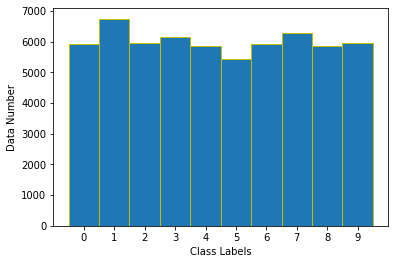

Check min and max values of data......  MIN:  0 MAX 255
Check data shape......  (60000, 28, 28)
Data reshaped......  (60000, 784) 




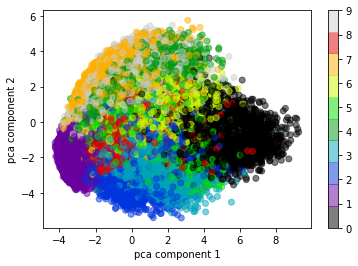

------------------------
| NETWORK ARCHITECTURE: |
------------------------
ANN LAYERS... 4
HIDDEN LAYERS... 2
input layer... input size... 784 ...
hidden layer1... neurons... 512
activation layer1... relu
hidden layer2... neurons... 256
activation layer2... relu
softmax output layer ... neurons... 10
LOSS... Categorical Cross-Entropy
OPTIMIZER... Mini-Batch Gradient Descent


---------------
| TRAINING... |
---------------
epoch: 0, acc: 0.806, loss: 0.739, lr: 0.09991154002653556
epoch: 1, acc: 0.914, loss: 0.297, lr: 0.09964364357205498
epoch: 2, acc: 0.931, loss: 0.239, lr: 0.09919775936169302
epoch: 3, acc: 0.942, loss: 0.202, lr: 0.09857628923094565
epoch: 4, acc: 0.950, loss: 0.174, lr: 0.09778256657632754
epoch: 5, acc: 0.956, loss: 0.153, lr: 0.09682082657620751
epoch: 6, acc: 0.962, loss: 0.136, lr: 0.09569616855401931
epoch: 7, acc: 0.965, loss: 0.123, lr: 0.09441451095176873
epoch: 8, acc: 0.969, loss: 0.111, lr: 0.0929825394699975
epoch: 9, acc: 0.971, loss: 0.102, lr: 0.0

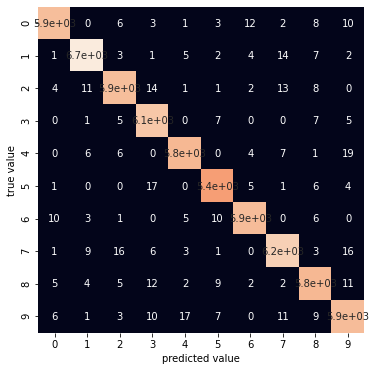

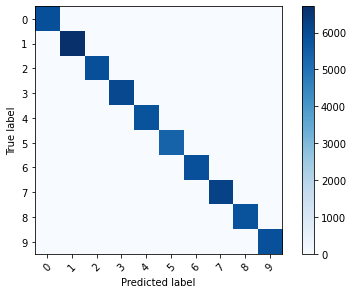

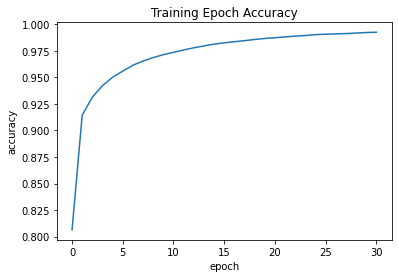

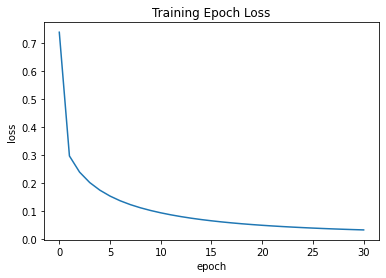

Testing Accuracy:  0.994


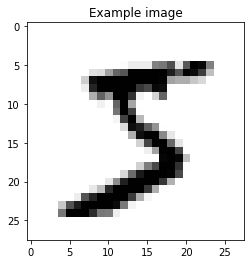

Predicted Labels:  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]
Actual Labels:  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]


In [16]:
    ann = ANN()
    ann.train_and_test()